# Data Preparation for GA blockgroup and precinct data

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import maup

## Import shapefiles with decennial data

In [73]:
ga_bgs_decennial = gpd.read_file("data/GA_block_groups/GA_block_groups.shp")

In [74]:
ga_blocks = gpd.read_file("data/GA_blocks_10/GA_blocks_2010.shp")

## Clean ACS data from NHGIS

* TOTPOP broked down by race and hispanic origin
* aggregate VAP counts

In [7]:
ga_bgs_acs = pd.read_csv("data/nhgis0028_csv/nhgis0028_ds239_20185_2018_blck_grp.csv")

In [8]:
ga_bgs_acs["GEOID"] = ga_bgs_acs["GISJOIN"].apply(lambda geoid: geoid[1:3] + geoid[4:7] + geoid[8:])

In [9]:
pop_cols_to_rename = {"AJWVE001": "TOTPOP18",
                     "AJWVE003": "NH_WHITE18",
                     "AJWVE004": "NH_BLACK18",
                     "AJWVE005": "NH_AMIN18",
                     "AJWVE006": "NH_ASIAN18",
                     "AJWVE007": "NH_NHPI18",
                     "AJWVE008": "NH_OTHER18",
                     "AJWVE009": "NH_2MORE18",
                     "AJWVE012": "HISP18",
                     "AJWVE013": "H_WHITE18",
                     "AJWVE014": "H_BLACK18",
                     "AJWVE015": "H_AMIN18",
                     "AJWVE016": "H_ASIAN18",
                     "AJWVE017": "H_NHPI18",
                     "AJWVE018": "H_OTHER18",
                     "AJWVE019": "H_2MORE18"}

In [10]:
ga_bgs_acs.rename(columns=pop_cols_to_rename,inplace=True)

In [11]:
u18_cols = (["AJWBE{:03}".format(i) for i in range(3,7)] 
          + ["AJWBE{:03}".format(i) for i in range(27,31)])
vap_cols = (["AJWBE{:03}".format(i) for i in range(7,26)] 
          + ["AJWBE{:03}".format(i) for i in range(31,50)])

In [12]:
## Sanity check that U18 + VAP is equal to TOTPOP for all blocks
(ga_bgs_acs[u18_cols].sum(axis=1) + ga_bgs_acs[vap_cols].sum(axis=1) == ga_bgs_acs.TOTPOP18).all()

True

In [13]:
ga_bgs_acs["U18_18"] = ga_bgs_acs[u18_cols].sum(axis=1)
ga_bgs_acs["VAP18"] = ga_bgs_acs[vap_cols].sum(axis=1)

In [14]:
ga_bgs_acs.head()

GISJOIN       YEAR  REGIONA  DIVISIONA    STATE  STATEA  \
0  G13000109501001  2014-2018      NaN        NaN  Georgia      13   
1  G13000109501002  2014-2018      NaN        NaN  Georgia      13   
2  G13000109502001  2014-2018      NaN        NaN  Georgia      13   
3  G13000109502002  2014-2018      NaN        NaN  Georgia      13   
4  G13000109502003  2014-2018      NaN        NaN  Georgia      13   

           COUNTY  COUNTYA  COUSUBA  PLACEA  ...  AJWVM015  AJWVM016  \
0  Appling County        1      NaN     NaN  ...        13        13   
1  Appling County        1      NaN     NaN  ...        13        13   
2  Appling County        1      NaN     NaN  ...        13        13   
3  Appling County        1      NaN     NaN  ...        13        13   
4  Appling County        1      NaN     NaN  ...        13        13   

   AJWVM017  AJWVM018  AJWVM019  AJWVM020  AJWVM021         GEOID  U18_18  \
0        13        13        13        13        13  130019501001     118   
1        13        13        13        13        13  130019501002     583   
2        13       200        13        13        13  130019502001     349   
3        13        13        13        13        13  130019502002     267   
4        13        13        13        13        13  130019502003     244   

   VAP18  
0    769  
1   1541  
2   1362  
3   1028  
4   1051  

[5 rows x 181 columns]

In [15]:
cols_to_drop = ['COUSUBA','PLACEA','CONCITA', 'RES_ONLYA','TRUSTA','AIANHHA','AITSCEA',
                'ANRCA','CBSAA','METDIVA','CSAA','NECTAA','NECTADIVA','CNECTAA', 'UAA',
                'SLDUA','SLDLA','ZCTA5A','SUBMCDA','SDELMA','SDSECA','SDUNIA',]

In [16]:
cols_to_drop.extend(list(ga_bgs_acs.filter(regex='AJW')))

In [17]:
ga_bgs_acs_clean = ga_bgs_acs.drop(columns=cols_to_drop)

In [18]:
ga_bgs_acs_clean.to_csv("data/GA_ACS_VAP_POP_bgs_2014-18.csv")

In [19]:
ga_bgs_acs_clean.columns

Index(['GISJOIN', 'YEAR', 'REGIONA', 'DIVISIONA', 'STATE', 'STATEA', 'COUNTY',
       'COUNTYA', 'TRACTA', 'BLKGRPA', 'CDCURRA', 'PUMA5A', 'BTTRA', 'BTBGA',
       'NAME_E', 'TOTPOP18', 'NH_WHITE18', 'NH_BLACK18', 'NH_AMIN18',
       'NH_ASIAN18', 'NH_NHPI18', 'NH_OTHER18', 'NH_2MORE18', 'HISP18',
       'H_WHITE18', 'H_BLACK18', 'H_AMIN18', 'H_ASIAN18', 'H_NHPI18',
       'H_OTHER18', 'H_2MORE18', 'NAME_M', 'GEOID', 'U18_18', 'VAP18'],
      dtype='object')

## Merge ACS with decennial shapefile

In [20]:
ga_bgs_decennial.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'group',
       'ALAND10', 'AWATER10', 'TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN',
       'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'HISP', 'H_WHITE',
       'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP',
       'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP', 'geometry'],
      dtype='object')

In [21]:
cols = ['TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN','NH_ASIAN', 'NH_NHPI', 
        'NH_OTHER', 'NH_2MORE', 'HISP', 'H_WHITE', 'H_BLACK', 'H_AMIN', 
        'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 
        'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP','2MOREVAP']

In [22]:
ga_bgs_decennial.rename(columns={k: "{}10".format(k) for k in cols}, inplace=True)

In [23]:
ga_bgs = pd.merge(ga_bgs_decennial, ga_bgs_acs_clean, on="GEOID")

In [24]:
ga_bgs.to_file("data/GA_blockgroups_2018/GA_blockgroups_2018.shp")

## Merge ACS POP/VAP with CPOP/CVAP data

In [3]:
ga_bgs = gpd.read_file("data/GA_blockgroups_2018/GA_blockgroups_2018.shp")

In [5]:
ga_citz_bgs = gpd.read_file("../shapes/Georgia/GA_block_groups/GA_block_groups_cvap_2018.shp")

In [17]:
citz_cols_to_rename = {'HCVAP': 'HCVAP18',
                     'NHCVAP': 'NHCVAP18',
                     '2MORECVAP': '2MORCVAP18',
                     'AMINCVAP': 'AMINCVAP18',
                     'ASIANCVAP': 'ACVAP18',
                     'BCVAP': 'BCVAP18',
                     'NHPICVAP': 'NHPICVAP18',
                     'WCVAP': 'WCVAP18',
                     'CVAP': 'CVAP18',
                     'HCPOP': 'HCPOP18',
                     'NHCPOP': 'NHCPOP18',
                     '2MORECPOP': '2MORCPOP18',
                     'AMINCPOP': 'AMINCPOP18',
                     'ASIANCPOP': 'ACPOP18',
                     'BCPOP': 'BCPOP18',
                     'NHPICPOP': 'NHPICPOP18',
                     'WCPOP': 'WCPOP18',
                     'CPOP': 'CPOP18'}

In [19]:
ga_citz_bgs.rename(columns=citz_cols_to_rename, inplace=True)

In [20]:
ga_citz_bgs.head()

STATEFP COUNTYFP TRACTCE BLKGRPCE         GEOID       NAMELSAD  MTFCC  \
0      13      133  950303        4  131339503034  Block Group 4  G5030   
1      13      133  950200        2  131339502002  Block Group 2  G5030   
2      13      133  950200        3  131339502003  Block Group 3  G5030   
3      13      133  950100        1  131339501001  Block Group 1  G5030   
4      13      133  950301        3  131339503013  Block Group 3  G5030   

  FUNCSTAT      ALAND    AWATER  ... HCPOP18 NHCPOP18 2MORCPOP18  AMINCPOP18  \
0        S   22290817   2102661  ...       0      295          0           0   
1        S   30644092    141901  ...      55      940          4           0   
2        S    1165721         0  ...       0      855          4           0   
3        S  250282378  15397206  ...      55     1190          0           0   
4        S   11161937   1443497  ...      60      695          0           0   

   ACPOP18  BCPOP18  NHPICPOP18  WCPOP18  CPOP18  \
0        0      100           0      195     295   
1        0      605           0      325     990   
2        4      545           0      305     855   
3        0      230           0      960    1245   
4       60       50           0      585     750   

                                            geometry  
0  POLYGON ((-83.27642 33.57801, -83.27362 33.581...  
1  POLYGON ((-83.11508 33.62270, -83.11462 33.622...  
2  POLYGON ((-83.08492 33.62225, -83.08448 33.622...  
3  POLYGON ((-83.40609 33.69837, -83.40442 33.698...  
4  POLYGON ((-83.24550 33.47403, -83.24504 33.474...  

[5 rows x 60 columns]

In [32]:
ga_block_groups = pd.merge(ga_bgs,
         ga_citz_bgs[['GEOID', 'HCVAP18', 'NHCVAP18', '2MORCVAP18', 'AMINCVAP18', 
                      'ACVAP18', 'BCVAP18', 'NHPICVAP18', 'WCVAP18', 'CVAP18', 
                      'HCPOP18', 'NHCPOP18', '2MORCPOP18', 'AMINCPOP18', 'ACPOP18',
                      'BCPOP18','NHPICPOP18', 'WCPOP18','CPOP18']], on="GEOID")

In [36]:
ga_block_groups.to_file("data/GA_blockgroups_2018/GA_blockgroups_all_pops.shp")

In [42]:
ga_block_groups.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'group',
       'ALAND10', 'AWATER10', 'TOTPOP10', 'NH_WHITE10', 'NH_BLACK10',
       'NH_AMIN10', 'NH_ASIAN10', 'NH_NHPI10', 'NH_OTHER10', 'NH_2MORE10',
       'HISP10', 'H_WHITE10', 'H_BLACK10', 'H_AMIN10', 'H_ASIAN10', 'H_NHPI10',
       'H_OTHER10', 'H_2MORE10', 'VAP10', 'HVAP10', 'WVAP10', 'BVAP10',
       'AMINVAP10', 'ASIANVAP10', 'NHPIVAP10', 'OTHERVAP10', '2MOREVAP10',
       'GISJOIN', 'YEAR', 'REGIONA', 'DIVISIONA', 'STATE', 'STATEA', 'COUNTY',
       'COUNTYA', 'TRACTA', 'BLKGRPA', 'CDCURRA', 'PUMA5A', 'BTTRA', 'BTBGA',
       'NAME_E', 'TOTPOP18', 'NH_WHITE18', 'NH_BLACK18', 'NH_AMIN18',
       'NH_ASIAN18', 'NH_NHPI18', 'NH_OTHER18', 'NH_2MORE18', 'HISP18',
       'H_WHITE18', 'H_BLACK18', 'H_AMIN18', 'H_ASIAN18', 'H_NHPI18',
       'H_OTHER18', 'H_2MORE18', 'NAME_M', 'U18_18', 'VAP18', 'geometry',
       'HCVAP18', 'NHCVAP18', '

## Maup 2014-18 ACS data to block and then up to (2016/2018) precincts

- Compare weighting by decenial VAP v. weighting by decenial TOTPOP

### 2014-18 ACS data on blocks

In [47]:
assignment = maup.assign(ga_blocks, ga_block_groups)

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

In [48]:
weights_TOTPOP = ga_blocks.TOTPOP / assignment.map(ga_block_groups.TOTPOP10)
weights_VAP = ga_blocks.VAP / assignment.map(ga_block_groups.VAP10)

In [63]:
cols = ['TOTPOP18', 'NH_WHITE18', 'NH_BLACK18', 'NH_AMIN18', 'NH_ASIAN18', 'NH_NHPI18', 
        'NH_OTHER18', 'NH_2MORE18', 'HISP18', 'H_WHITE18', 'H_BLACK18', 'H_AMIN18', 
        'H_ASIAN18', 'H_NHPI18', 'H_OTHER18', 'H_2MORE18', 'U18_18', 'VAP18', 
        'HCVAP18', 'NHCVAP18', '2MORCVAP18', 'AMINCVAP18', 'ACVAP18', 'BCVAP18',
        'NHPICVAP18', 'WCVAP18', 'CVAP18', 'HCPOP18', 'NHCPOP18', '2MORCPOP18',
        'AMINCPOP18', 'ACPOP18', 'BCPOP18', 'NHPICPOP18', 'WCPOP18', 'CPOP18']

In [64]:
prorated_TOTPOP = maup.prorate(assignment, ga_block_groups[cols], weights_TOTPOP)
prorated_VAP = maup.prorate(assignment, ga_block_groups[cols], weights_VAP)

In [68]:
prorated_TOTPOP.head()

TOTPOP18  NH_WHITE18  NH_BLACK18  NH_AMIN18  NH_ASIAN18  NH_NHPI18  \
0   5.469799    2.644295    2.825503   0.000000    0.000000        0.0   
1  21.800298   20.737705    0.402757   0.145678    0.000000        0.0   
2   0.000000    0.000000    0.000000   0.000000    0.000000        0.0   
3   0.000000    0.000000    0.000000   0.000000    0.000000        0.0   
4   6.975806    2.588710    3.290323   0.000000    0.346774        0.0   

   NH_OTHER18  NH_2MORE18    HISP18  H_WHITE18  ...     CVAP18   HCPOP18  \
0    0.000000    0.000000  0.000000   0.000000  ...   4.731544  0.000000   
1    0.059985    0.222802  0.231371   0.231371  ...  18.081222  0.214232   
2    0.000000    0.000000  0.000000   0.000000  ...   0.000000  0.000000   
3    0.000000    0.000000  0.000000   0.000000  ...   0.000000  0.000000   
4    0.000000    0.000000  0.750000   0.750000  ...   5.120968  0.564516   

    NHCPOP18  2MORCPOP18  AMINCPOP18   ACPOP18   BCPOP18  NHPICPOP18  \
0   5.469799    0.000000    0.000000  0.000000  2.818792         0.0   
1  21.551788    0.214232    0.128539  0.000000  0.385618         0.0   
2   0.000000    0.000000    0.000000  0.000000  0.000000         0.0   
3   0.000000    0.000000    0.000000  0.000000  0.000000         0.0   
4   6.129032    0.000000    0.000000  0.241935  3.306452         0.0   

     WCPOP18     CPOP18  
0   2.651007   5.469799  
1  20.780551  21.766021  
2   0.000000   0.000000  
3   0.000000   0.000000  
4   2.580645   6.693548  

[5 rows x 36 columns]

In [72]:
prorated_VAP.head()

TOTPOP18  NH_WHITE18  NH_BLACK18  NH_AMIN18  NH_ASIAN18  NH_NHPI18  \
0   6.331853    3.061043    3.270810   0.000000    0.000000        0.0   
1  16.787817   15.969543    0.310152   0.112183    0.000000        0.0   
2   0.000000    0.000000    0.000000   0.000000    0.000000        0.0   
3   0.000000    0.000000    0.000000   0.000000    0.000000        0.0   
4   5.258359    1.951368    2.480243   0.000000    0.261398        0.0   

   NH_OTHER18  NH_2MORE18    HISP18  H_WHITE18  ...     CVAP18   HCPOP18  \
0    0.000000    0.000000  0.000000   0.000000  ...   5.477248  0.000000   
1    0.046193    0.171574  0.178173   0.178173  ...  13.923858  0.164975   
2    0.000000    0.000000  0.000000   0.000000  ...   0.000000  0.000000   
3    0.000000    0.000000  0.000000   0.000000  ...   0.000000  0.000000   
4    0.000000    0.000000  0.565350   0.565350  ...   3.860182  0.425532   

    NHCPOP18  2MORCPOP18  AMINCPOP18   ACPOP18   BCPOP18  NHPICPOP18  \
0   6.331853    0.000000    0.000000  0.000000  3.263041         0.0   
1  16.596447    0.164975    0.098985  0.000000  0.296954         0.0   
2   0.000000    0.000000    0.000000  0.000000  0.000000         0.0   
3   0.000000    0.000000    0.000000  0.000000  0.000000         0.0   
4   4.620061    0.000000    0.000000  0.182371  2.492401         0.0   

     WCPOP18     CPOP18  
0   3.068812   6.331853  
1  16.002538  16.761421  
2   0.000000   0.000000  
3   0.000000   0.000000  
4   1.945289   5.045593  

[5 rows x 36 columns]

### Aggregate from blocks to precincts

In [76]:
ga_pcts_2016 = gpd.read_file("data/GA_precincts_16/GA_precincts16.shp")

In [78]:
ga_pcts_2018 = gpd.read_file("data/GA_2018_precincts/GA_2018_precincts.shp")

In [102]:
ga_pcts_2016.shape, ga_pcts_2018.shape, 

((2664, 42), (2659, 74))

In [84]:
ga_pcts_2018 = ga_pcts_2018.to_crs(ga_pcts_2016.crs)

In [87]:
ga_blocks = ga_blocks.to_crs(ga_pcts_2016.crs)

In [89]:
assign_pct_2016 = maup.assign(ga_blocks, ga_pcts_2016)
assign_pct_2018 = maup.assign(ga_blocks, ga_pcts_2018)

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/Users/smaug/anaconda3/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a

In [96]:
pct_2016_TOTPOP = prorated_TOTPOP.groupby(assign_pct_2016).sum()
pct_2016_VAP = prorated_VAP.groupby(assign_pct_2016).sum()

pct_2018_TOTPOP = prorated_TOTPOP.groupby(assign_pct_2018).sum()
pct_2018_VAP = prorated_VAP.groupby(assign_pct_2018).sum()

In [298]:
ga_pcts_2016[cols] = pct_2016_VAP

In [301]:
ga_pcts_2018[cols] = pct_2018_VAP

In [302]:
ga_pcts_2016.to_file("data/GA_precincts_all_pops/GA_precincts_2016.shp")

In [303]:
ga_pcts_2018.to_file("data/GA_precincts_all_pops/GA_precincts_2018.shp")

## Investigate Error between dissagregation methods

In [213]:
acs_tot_m = pct_2016_TOTPOP[['TOTPOP18', 'NH_WHITE18', 'NH_BLACK18', 'NH_AMIN18', 'NH_ASIAN18', 
                         'NH_NHPI18', 'NH_OTHER18', 'NH_2MORE18', 'HISP18','VAP18']].values
acs_vap_m = pct_2016_VAP[['TOTPOP18', 'NH_WHITE18', 'NH_BLACK18', 'NH_AMIN18', 'NH_ASIAN18', 
                         'NH_NHPI18', 'NH_OTHER18', 'NH_2MORE18', 'HISP18','VAP18']].values
dec_m = ga_pcts_2016[["TOTPOP", "NH_WHITE", "NH_BLACK", "NH_AMIN", "NH_ASIAN", "NH_NHPI", 
                      "NH_OTHER", "NH_2MORE", "HISP", "VAP"]].values

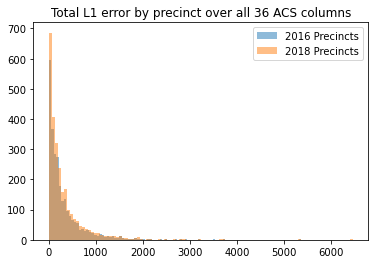

In [244]:
plt.hist(np.abs(pct_2016_TOTPOP.values - pct_2016_VAP.values).sum(axis=1), bins=100,
         alpha=0.5, histtype="stepfilled", label="2016 Precincts")
plt.hist(np.abs(pct_2018_TOTPOP.values - pct_2018_VAP.values).sum(axis=1), bins=100,
         alpha=0.5, histtype="stepfilled", label="2018 Precincts")
plt.title("Total L1 error by precinct over all 36 ACS columns")
plt.legend()
plt.show()

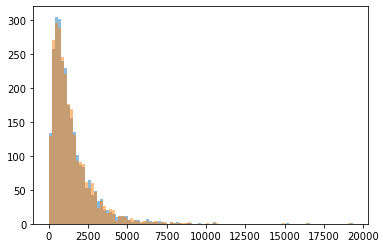

In [243]:
plt.hist(np.abs(acs_tot_m - dec_m).sum(axis=1), bins=100, alpha=0.5, histtype="stepfilled", label="TOTPOP dissaggreation")
plt.hist(np.abs(acs_vap_m - dec_m).sum(axis=1), bins=100, alpha=0.5, histtype="stepfilled", label="VAP dissaggreation")
plt.show()

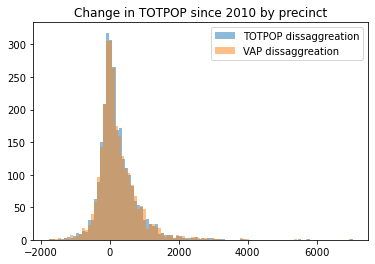

In [294]:
plt.hist(pct_2016_TOTPOP.TOTPOP18 - ga_pcts_2016["TOTPOP"],bins=100,
         alpha=0.5, histtype="stepfilled", label="TOTPOP dissaggreation")
plt.hist(pct_2016_VAP.TOTPOP18 - ga_pcts_2016["TOTPOP"],bins=100,
        alpha=0.5, histtype="stepfilled", label="VAP dissaggreation")
plt.legend()
plt.title("Change in TOTPOP since 2010 by precinct")
plt.show()

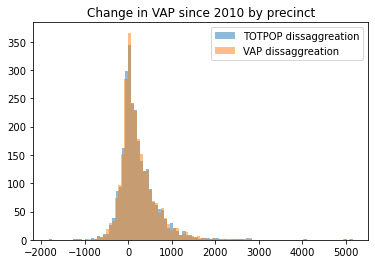

In [295]:
plt.hist((acs_tot_m - dec_m)[:,9],bins=100,
         alpha=0.5, histtype="stepfilled", label="TOTPOP dissaggreation")
plt.hist((acs_vap_m - dec_m)[:,9],bins=100,
        alpha=0.5, histtype="stepfilled", label="VAP dissaggreation")
plt.title("Change in VAP since 2010 by precinct")
plt.legend()
plt.show()

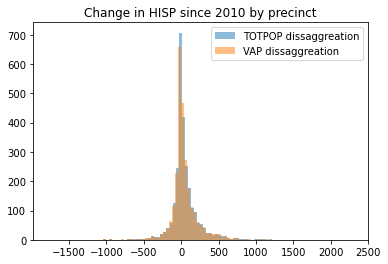

In [286]:
plt.hist((acs_tot_m - dec_m)[:,8], bins=100,
         alpha=0.5, histtype="stepfilled", label="TOTPOP dissaggreation")
plt.hist((acs_vap_m - dec_m)[:,8], bins=100,
        alpha=0.5, histtype="stepfilled", label="VAP dissaggreation")
plt.title("Change in HISP since 2010 by precinct")
plt.legend()
plt.show()

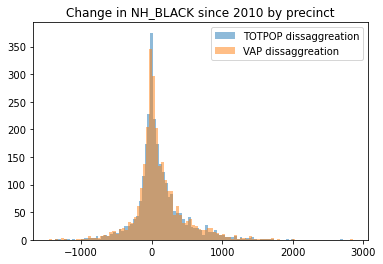

In [245]:
plt.hist((acs_tot_m - dec_m)[:,2], bins=100,
         alpha=0.5, histtype="stepfilled", label="TOTPOP dissaggreation")
plt.hist((acs_vap_m - dec_m)[:,2], bins=100,
        alpha=0.5, histtype="stepfilled", label="VAP dissaggreation")
plt.title("Change in NH_BLACK since 2010 by precinct")
plt.legend()
plt.show()

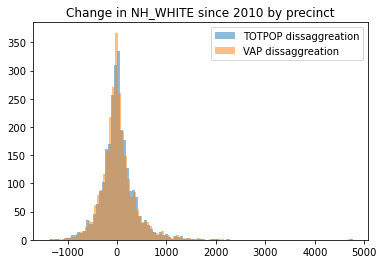

In [246]:
plt.hist((acs_tot_m - dec_m)[:,1], bins=100,
         alpha=0.5, histtype="stepfilled", label="TOTPOP dissaggreation")
plt.hist((acs_vap_m - dec_m)[:,1], bins=100,
        alpha=0.5, histtype="stepfilled", label="VAP dissaggreation")
plt.title("Change in NH_WHITE since 2010 by precinct")
plt.legend()
plt.show()

In [159]:
df_2016 = (pct_2016_TOTPOP - pct_2016_VAP).stack().reset_index().set_index("level_0").rename(columns={"level_1": "var", 0: "error"})
df_2018 = (pct_2018_TOTPOP - pct_2018_VAP).stack().reset_index().set_index("level_0").rename(columns={"level_1": "var", 0: "error"})
df = df_2016.assign(year=2016).append(df_2018.assign(year=2018))

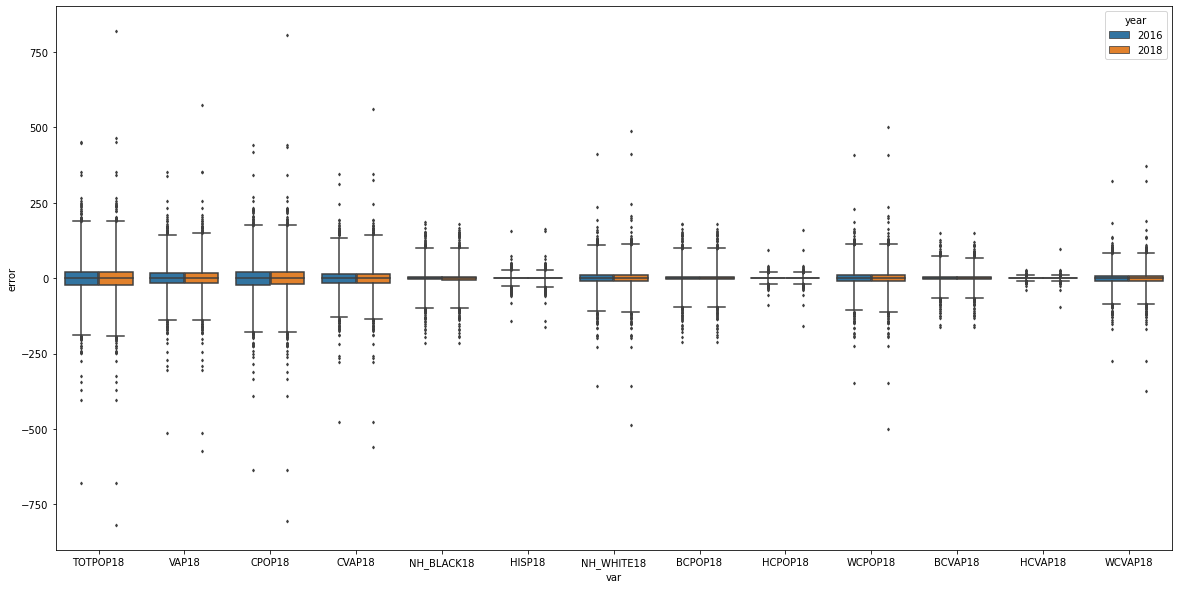

In [161]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df, y="error", x="var", hue="year", whis=(1,99), fliersize=2,
            order=['TOTPOP18', 'VAP18', 'CPOP18' ,'CVAP18', 'NH_BLACK18', 'HISP18', 'NH_WHITE18',
                   'BCPOP18', "HCPOP18", "WCPOP18",'BCVAP18', 'HCVAP18', 'WCVAP18'])
plt.show()

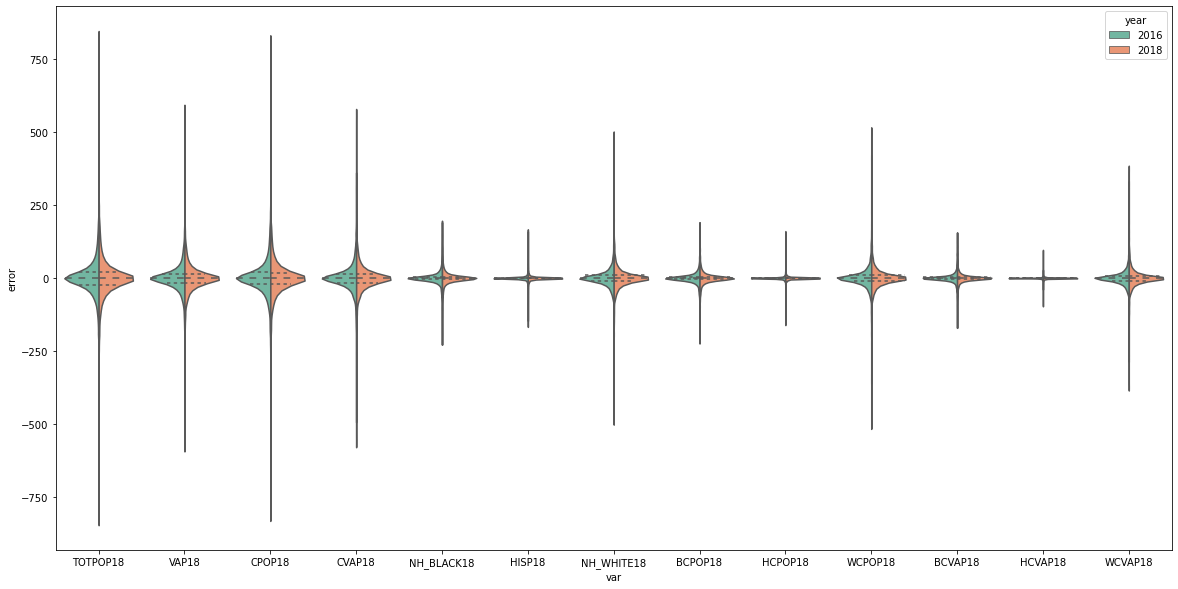

In [171]:
plt.figure(figsize=(20,10))
sns.violinplot(data=df, y="error", x="var", hue="year", split=True, scale="count",palette="Set2",
            order=['TOTPOP18', 'VAP18', 'CPOP18' ,'CVAP18', 'NH_BLACK18', 'HISP18', 'NH_WHITE18',
                   'BCPOP18', "HCPOP18", "WCPOP18",'BCVAP18', 'HCVAP18', 'WCVAP18'], inner="quartile")
plt.show()

In [260]:
(pct_2016_TOTPOP - pct_2016_VAP).query("TOTPOP18 > 100 or TOTPOP18 < -100")

TOTPOP18  NH_WHITE18  NH_BLACK18  NH_AMIN18  NH_ASIAN18  NH_NHPI18  \
1     135.493961  100.647242   10.645629   0.000000    2.631955        0.0   
21   -102.569011  -50.942459  -23.908830   0.000000   -5.936761        0.0   
38    143.009568   79.026116   31.726216   0.000000    6.851624        0.0   
40   -198.150281 -141.254786  -32.946987   0.000000   -6.555721        0.0   
57    120.218839   36.837276   74.081321   0.000000    0.719388        0.0   
...          ...         ...         ...        ...         ...        ...   
2630 -343.555682 -116.904761  -73.741102  -0.512472   -4.571081        0.0   
2639 -113.877421 -104.330347   -2.656018   0.000000   -1.023110        0.0   
2644  149.162136   36.850564   90.848930   0.000000    3.736561        0.0   
2650 -166.866704  -22.894716 -129.492195  -0.398656   -1.275700        0.0   
2657  122.432063    1.706523  113.855692   1.093925    0.000000        0.0   

        NH_OTHER18    NH_2MORE18      HISP18   H_WHITE18  ...      CVAP18  \
1     0.000000e+00  6.479201e+00   15.089934    7.711887  ...   94.814429   
21   -1.776357e-15 -1.036535e+01  -11.415611   -0.724542  ...  -76.645269   
38    2.998232e-01  1.086506e+01   14.240732    3.018020  ...  106.696057   
40   -1.256498e+00 -3.889780e+00  -12.246509  -10.513919  ... -149.961356   
57    0.000000e+00  1.376449e+00    7.204405    3.973006  ...   86.543416   
...            ...           ...         ...         ...  ...         ...   
2630  6.548230e-03 -4.861902e+00 -142.970913 -118.222764  ... -188.502604   
2639 -5.515895e-01 -4.168754e+00   -1.147602   -1.147602  ...  -89.946303   
2644  0.000000e+00  9.096438e-01   16.816437    9.251500  ...   96.214556   
2650  0.000000e+00 -2.879881e+00   -9.925556   -9.806947  ... -118.869255   
2657  0.000000e+00  7.105427e-15    5.775923    0.000000  ...   76.355950   

        HCPOP18    NHCPOP18  2MORCPOP18  AMINCPOP18   ACPOP18     BCPOP18  \
1     10.881694  120.088732    5.757064    0.000000  2.445091   10.631179   
21   -11.287210  -88.543003   -9.462750    0.000000 -5.059715  -23.854159   
38    14.082692  126.085953    9.945799    0.000000  6.011453   31.701298   
40   -11.697056 -182.132153   -4.087257    0.000000 -5.333868  -31.841591   
57     3.910610  109.589394    1.408890    0.000000  0.739970   71.137798   
...         ...         ...         ...         ...       ...         ...   
2630 -88.364793 -195.376333   -4.186625   -0.345281 -4.348301  -73.454215   
2639  -1.023567 -112.071790   -4.190174    0.000000 -1.023110   -2.677437   
2644  16.172397  127.685225    0.834075    0.000000  0.000000   90.414651   
2650  -3.705281 -150.470721   -3.039343   -0.398656 -1.195969 -123.095445   
2657   3.281774  112.236684    0.000000    1.093925  0.000000  110.267619   

      NHPICPOP18     WCPOP18      CPOP18  
1            0.0  101.255398  130.846805  
21           0.0  -50.020798  -99.830213  
38           0.0   78.348449  140.168645  
40           0.0 -141.008085 -193.808350  
57           0.0   36.356151  113.500004  
...          ...         ...         ...  
2630         0.0 -113.093389 -283.773867  
2639         0.0 -104.181069 -113.095357  
2644         0.0   36.299469  143.857622  
2650         0.0  -22.940636 -154.176003  
2657         0.0    0.875140  115.518458  

[256 rows x 36 columns]

In [261]:
(pct_2018_TOTPOP - pct_2018_VAP).query("TOTPOP18 > 100 or TOTPOP18 < -100")

TOTPOP18  NH_WHITE18  NH_BLACK18  NH_AMIN18  NH_ASIAN18  NH_NHPI18  \
16    135.493961  100.647242   10.645629   0.000000    2.631955   0.000000   
24   -113.060294  -59.188213  -41.458600   0.071730   -5.863401   0.000000   
25   -132.284147  -18.697138 -107.699156  -0.022627    0.000000  -0.407282   
31    174.852784   28.565947  138.211332   0.039523    0.000000   0.711419   
33    114.520472   -1.082684  120.156374  -0.000661   -0.062041  -0.011891   
...          ...         ...         ...        ...         ...        ...   
2626  195.308183   47.006320   37.847149   0.000000   79.712953   0.000000   
2634  131.744597    1.022967  106.306870   3.151965   -0.359352   0.076877   
2635 -195.797499  -16.840005 -152.924528  -3.151965   -0.162567  -0.076877   
2637 -104.153227   -1.739480  -99.290934   0.000000    0.000000   0.000000   
2658  190.153325   44.510672  131.907707   0.010867    7.404045   0.000000   

      NH_OTHER18  NH_2MORE18     HISP18  H_WHITE18  ...      CVAP18  \
16      0.000000    6.479201  15.089934   7.711887  ...   94.814429   
24      0.000000   -4.644218  -1.977591  -1.360546  ...  -72.229564   
25      0.000000   -1.291493  -4.166451  -0.091501  ...  -89.201517   
31     -1.665304    2.233066   6.756800   0.059285  ...  116.579829   
33      3.574613   -0.451745  -7.601493  -4.091905  ...   81.946418   
...          ...         ...        ...        ...  ...         ...   
2626    0.000000    5.098917  25.642844  21.559083  ...  122.107299   
2634    4.228246   14.818641   2.498383   0.192151  ...   82.080076   
2635   -4.228246  -15.963036  -2.450274  -0.176115  ... -128.275498   
2637    0.000000   -0.190718  -2.932095  -0.127145  ...  -71.612228   
2658    0.000000    0.021243   6.298790   5.547004  ...   90.373761   

        HCPOP18    NHCPOP18  2MORCPOP18  AMINCPOP18    ACPOP18     BCPOP18  \
16    10.881694  120.088732    5.757064    0.000000   2.445091   10.631179   
24     0.133886 -105.197745   -4.656149    0.079700  -3.148296  -38.429930   
25    -4.060099 -123.697630   -1.314120   -0.045254   0.000000 -103.275627   
31     6.710099  160.396119    2.272590    0.079047   0.000000  128.812045   
33    -5.096778  121.267006   -0.489438   -0.001321   0.000000  123.704685   
...         ...         ...         ...         ...        ...         ...   
2626  24.135960  142.225849    4.552625    0.000000  59.441084   32.853097   
2634   0.990485  125.334096   14.863368    3.075088  -0.299460  107.551686   
2635  -0.971981 -189.526708  -15.963036   -3.075088  -0.135473 -154.168110   
2637  -2.883061  -98.095387   -0.192196    0.000000   0.000000  -96.247605   
2658   5.130756  167.727314    0.020951    0.012074   6.515479  121.654795   

      NHPICPOP18     WCPOP18      CPOP18  
16      0.000000  101.255398  130.846805  
24      0.000000  -59.007504 -105.014152  
25     -0.395968  -18.711916 -127.757730  
31      0.691658   28.619826  167.106218  
33     -0.011561   -1.915908  116.102113  
...          ...         ...         ...  
2626    0.000000   45.379042  166.361809  
2634    0.307509    0.367049  126.324580  
2635   -0.307509  -16.185001 -190.498690  
2637    0.000000   -1.763626 -101.086488  
2658    0.000000   39.861986  172.858069  

[263 rows x 36 columns]

In [277]:
df.query("error > 450")

var       error  year
level_0                              
2061       TOTPOP18  451.527913  2016
1316       TOTPOP18  818.854726  2018
1316     NH_WHITE18  486.613811  2018
1316          VAP18  572.983212  2018
1316       NHCVAP18  464.938731  2018
1316         CVAP18  560.077439  2018
1316       NHCPOP18  647.770510  2018
1316        WCPOP18  501.339628  2018
1316         CPOP18  805.783495  2018
1681       TOTPOP18  463.273265  2018
1827       TOTPOP18  451.527913  2018

In [275]:
df.query("error < -600")

var       error  year
level_0                            
1268     TOTPOP18 -679.666350  2016
1268       CPOP18 -635.509781  2016
1318     TOTPOP18 -818.854726  2018
1318     NHCPOP18 -647.770510  2018
1318       CPOP18 -805.783495  2018
1677     TOTPOP18 -679.666350  2018
1677       CPOP18 -635.509781  2018